In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/cotton-leaf-tree-plant-indian-beautiful-yellow-flower-morning-image-228974057.webp
/kaggle/input/images/1116130.jpg
/kaggle/input/images/1234095-SMPT.jpg


## **Step: 1 Downloading Cotton Disease Dataset**

In [2]:
!kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/janmejaybhoi/cotton-disease-dataset
License(s): CC0-1.0
 93%|██████████████████████████████████████   | 137M/148M [00:00<00:00, 243MB/s]
100%|█████████████████████████████████████████| 148M/148M [00:00<00:00, 234MB/s]


## **Step:2 Extract the Dataset zip file**

In [3]:
import zipfile

# Path to the downloaded zip file
local_zip = '/kaggle/working/cotton-disease-dataset.zip'

# Directory where the dataset will be extracted
extract_dir = '/kaggle/working/'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Dataset extracted to /kaggle/working/


## **Step:3 Train and Validation Path**

In [4]:
train_path='/kaggle/working/Cotton Disease/train'
val_path='/kaggle/working/Cotton Disease/test'

image_size=[242,242]

## **Step:4 Import Important Libraries**

In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

2024-07-25 13:10:41.005156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 13:10:41.005256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 13:10:41.131504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Step:4 Preprocess The Data**

In [6]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)  # Rescale and split data for validation

train_generator = datagen.flow_from_directory(
    '/kaggle/working/Cotton Disease/train',
    target_size=(242, 242),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/kaggle/working/Cotton Disease/test',
    target_size=(242, 242),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1562 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


## **Step:5 Import Resnet50 Model**

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(242,242,3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False

In [9]:
  # useful for getting number of output classes
folders = glob('/kaggle/working/Cotton Disease/train')

In [10]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)

In [11]:
num_classes = 4
prediction = Dense(num_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=base_model.input, outputs=prediction)

## Model Summary

In [12]:
# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 242, 242,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 248, 248,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 121, 121,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 121, 121,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 121, 121,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 123, 123,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 61, 61,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 61, 61,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 61, 61,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 61, 61,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 61, 61,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 61, 61,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 61, 61,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 61, 61,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 61, 61,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 61, 61,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 61, 61,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,004 (91.98 MB)

 Trainable params: 524,292 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## **Step:6 Compile the Model**

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## **Step:7 Fit the Model**

In [14]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
    
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/48 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4141 - loss: 10.7271 

I0000 00:00:1721913087.851012     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.2909 - loss: 17.6166 - val_accuracy: 0.3500 - val_loss: 4.4486
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4375 - loss: 4.1891 - val_accuracy: 0.3500 - val_loss: 3.5373
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.4791 - loss: 2.3968 - val_accuracy: 0.4000 - val_loss: 2.2854
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 2.1077 - val_accuracy: 0.3000 - val_loss: 1.8627
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5780 - loss: 1.3324 - val_accuracy: 0.4500 - val_loss: 2.7072
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 1.9127 - val_accuracy: 0.5500 - val_loss: 2.9706
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.5154 - loss: 2.0242 - val_accuracy: 0.6000 - val_loss: 2.1279
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7500 - loss: 1.3597 - val_accuracy: 0.4500 - val_loss: 2.2147
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6760 - loss: 1.0820 - val_accuracy: 0.7000 - val_loss: 0.6428
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.4555 - val_accuracy: 0.7500 - val_loss: 0.646

## **Step:8 Evaluate the Model**

In [15]:
loss, accuracy = model.evaluate(validation_generator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5500 - loss: 1.7103
Test Loss: 1.7102906703948975
Test Accuracy: 0.550000011920929


## **Step:9 Plot the Accuracy Graph**

In [16]:
import matplotlib.pyplot as plt

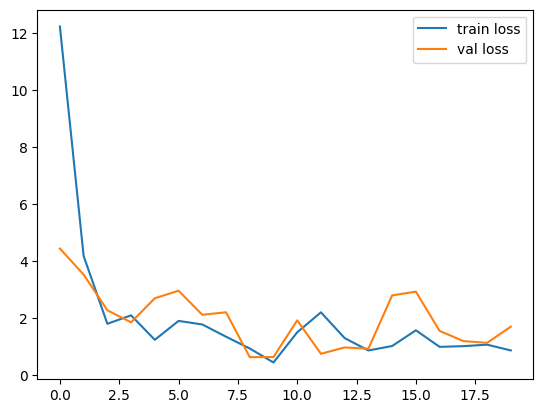

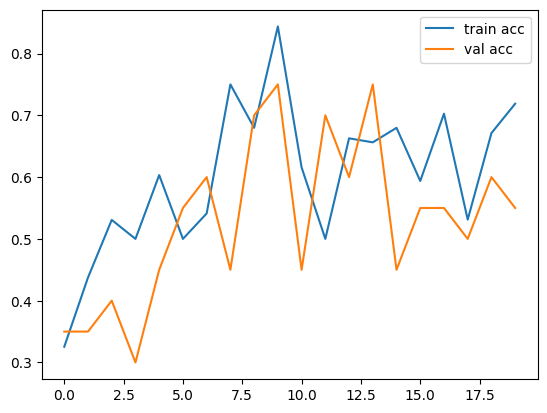

<Figure size 640x480 with 0 Axes>

In [17]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## **Step:10 Save the Model**

In [20]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

## **Step:11 Predict the Validation images**

In [22]:
y_pred = model.predict(validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [23]:
import numpy as np

np.argmax(y_pred, axis=1)



array([0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 1, 3, 3, 3])

## **Step:12 Load the model**

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


model=load_model('model_resnet50.h5')

## **Step:13 Load the Unseen Image**

In [42]:
img=image.load_img('/kaggle/input/images/cotton-leaf-tree-plant-indian-beautiful-yellow-flower-morning-image-228974057.webp',target_size=(242,242))

## **Step:13 Preprocess the Unseen image and Predict the image Disease**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3
Predicted class: diseased cotton plant


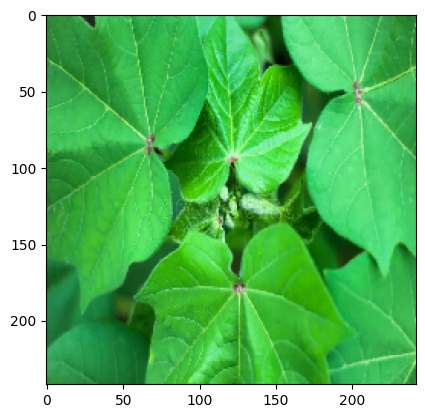

In [43]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(242, 242))  # Load and resize the image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image array
    return img_array


def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the highest probability
    return predicted_class_index

predictions = []

class_labels = {2:"diseased cotton leaf",3:"diseased cotton plant",0:"fresh cotton leaf",1:"fresh cotton plant"}


img_path = '/kaggle/input/images/cotton-leaf-tree-plant-indian-beautiful-yellow-flower-morning-image-228974057.webp'  # Path to the image you want to predict
predicted_class_index = predict_image(img_path)

print(predicted_class_index)
predicted_class_label = class_labels[predicted_class_index]

plt.imshow(img)
print(f'Predicted class: {predicted_class_label}')